# Imitation Learning - Sim

This notebook outlines the work undertaken as part of the MSc Robotics Thesis at Cranfield University. The notebook constructs a context-adaptation model that can generalise between multiple viewing angles of a task, based on the work of: *Y. Liu et. Al, Learning to Imitate Behaviors from Raw Video
via Context Translation*.

This notebook outlines the process in Simulation, using real-world data.

In [5]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.io import gfile
import imageio
import pickle
import PIL
import PIL.Image as Image
import scipy.misc
import sys
import skvideo
import skvideo.io
from IPython.display import HTML
import imageio
from tensorflow.python.framework import ops
%matplotlib inline

---
## Loading Data

This section loads in the dataset that was constructed, resizing the videos to ensure they are consistent. A transformation is applied to the raw footage, to facilitate the performance of the model.

In [6]:
# Function to resize and transform images
def transform(image, resize_height=48, resize_width=48):
    cropped_image = np.array(Image.fromarray(image).resize((48, 48)))
    return np.array(cropped_image)/127.5 - 1

In [7]:
# Inverese transform of the image
def inverse_transform(images):
    return (images + 1.)/2.

In [4]:
# To run this section, either import the expert_push.pkl file to automatically launch RLlab (provided it's setup correctly)
# and generate the dataset. Alternatively, run the gen_videos.py file inside RLlab, save the generated videos and provide the
# dataset path to the "vids = gfile.Glob("XXX")" line, replacing the "XXX" with the file path. The pickle method is preferable.

# vids = gfile.Glob("XXX")
vids = pickle.load(open('.\expert_push.pkl', 'rb'))

# Defining array to store data
idata = [[] for _ in range(50)]
# Initializing variable for number of failed attempts
nfail = 0
# Dimensions of the video
idim = (64, 64)
# Number of iterations
itr = 0
# Shuffling videos
np.random.shuffle(vids)

# Iterating through the list of videos
for name in vids:
    try:
        # Reading the video file
        vid = imageio.get_reader(name,  'ffmpeg')
        # Printing every 100 iterations
        if itr % 100 == 0:
            print(itr, map(len, idata))

        nlen = len(vid)
        # Initializing/resetting array to store frames
        frames = []
        
        # Iterating through the frames of each video
        for j in range(50):
            # Extracting frames from video
            frame = transform(vid.get_data(j))
            # Appending frames to array
            frames.append(frame)
        for j, f in enumerate(frames):
            # Appending video to array
            idata[j].append(f)
        itr += 1
    except:
        nfail += 1
        # Printing error
        print("Unexpected error:", sys.exc_info())
        print(name)
        # Exiting if more than 10 fails occur
        if nfail > 10:
            break

ModuleNotFoundError: No module named 'path'

In [3]:
# Assigning data to a variable
vdata = np.array(idata)
vdata.shape

NameError: name 'idata' is not defined

In [4]:
# Loading previous data
vdata = np.load('vdata_realnew200.npy')
vdata.shape

(50, 200, 36, 64, 3)

---
## Model Building

This section defines the encoders and decoders for the context-translation archtiecture .

In [8]:
# Defining leaky ReLu
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [9]:
# Defining 2d convolution
def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                  initializer=tf.truncated_normal_initializer(stddev=stddev))
        
        # Defining convolution parameters
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
    return conv

In [10]:
# Class for batch normalisation
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon  = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):
        return tf.contrib.layers.batch_norm(x,
                      decay=self.momentum, 
                      updates_collections=None,
                      epsilon=self.epsilon,
                      scale=True,
                      is_training=tftrain,
                      scope=self.name)

In [11]:
# Function for linear activation
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
              initializer=tf.constant_initializer(bias_start))
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias

In [12]:
# Function for deconvolution 2D
def deconv2d(input_, output_shape,
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                  initializer=tf.random_normal_initializer(stddev=stddev))

        try:
            # Defining deconvolution
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

In [15]:
# Class building overall model
class ContextAE:
    def __init__(self, gf_dim=64, df_dim=64,
                 gfc_dim=1024, dfc_dim=1024,
                 c_dim=3):
        # Image dimensions (H)
        self.gf_dim = gf_dim
        # Image dimensions (W)
        self.df_dim = df_dim
        # Bandwidth (RGB, G, etc)
        self.c_dim = c_dim
        
        # Filter size
        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim

    
    # Building the model
    def build(self, image):
        # Finding shape of dataset
        imgshape = image.get_shape().as_list()
        print(imgshape)
        self.output_height, self.output_width = imgshape[-3:-1]
        # Defining batch size
        self.batch_size = imgshape[1]
        # Feature size
        featsize = 1024
        # Defining source demonstration
        srcimg = image[0]
        # Defining target context image
        tgtimg = image[2]
        # Defining target video
        tgtctx = image[1]
        
        
        # Encoder 2
        with tf.variable_scope("conv_context") as scope:
            # Convolution of static context image
            tgtctx_h0 = lrelu(conv2d(tgtctx, self.df_dim, name='h0_conv'))
            tgtctx_h1 = lrelu(conv2d(tgtctx_h0, self.df_dim*2, name='h1_conv'))
            tgtctx_h2 = lrelu(conv2d(tgtctx_h1, self.df_dim*4, name='h2_conv'))
            tgtctx_h3 = lrelu(conv2d(tgtctx_h2, self.df_dim*8, name='h3_conv'))
            tgtctx_h4 = lrelu(linear(tf.reshape(tgtctx_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            tgtctx_z = linear(tgtctx_h4, featsize, 'hz_lin')
        
        # Encoder 1
        with tf.variable_scope("conv") as scope:
            # Convolution of demonstration
            srcimg_h0 = lrelu(conv2d(srcimg, self.df_dim, name='h0_conv'))
            srcimg_h1 = lrelu(conv2d(srcimg_h0, self.df_dim*2, name='h1_conv'))
            srcimg_h2 = lrelu(conv2d(srcimg_h1, self.df_dim*4, name='h2_conv'))
            srcimg_h3 = lrelu(conv2d(srcimg_h2, self.df_dim*8, name='h3_conv'))
            print(srcimg_h3.get_shape())
            srcimg_h4 = lrelu(linear(tf.reshape(srcimg_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            srcimg_z = lrelu(linear(srcimg_h4, featsize, 'hz_lin'))
            
            scope.reuse_variables()
            
            # Convolution of target
            tgtimg_h0 = lrelu(conv2d(tgtimg, self.df_dim, name='h0_conv'))
            tgtimg_h1 = lrelu(conv2d(tgtimg_h0, self.df_dim*2, name='h1_conv'))
            tgtimg_h2 = lrelu(conv2d(tgtimg_h1, self.df_dim*4, name='h2_conv'))
            tgtimg_h3 = lrelu(conv2d(tgtimg_h2, self.df_dim*8, name='h3_conv'))
            tgtimg_h4 = lrelu(linear(tf.reshape(tgtimg_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            tgtimg_z = lrelu(linear(tgtimg_h4, featsize, 'hz_lin'))
        
        # Translation module
        with tf.variable_scope("translate") as scope:
            # Leaky ReLu activation, concatenation of t
            trans_h0 = lrelu(linear(tf.concat([srcimg_z, tgtctx_z], 1), featsize, 'trans_h0'))
            trans_z = linear(trans_h0, featsize, 'trans_z')
            self.translated_z = trans_z
        
        # Deconvolutions
        with tf.variable_scope("deconv") as scope:
            # Strides
            s_h, s_w = self.output_height, self.output_width
            s_h2, s_h4, s_h8, s_h16 = \
                int(s_h/2), int(s_h/4), int(s_h/8), int(s_h/16)
            s_w2, s_w4, s_w8, s_w16 = \
                int(s_w/2), int(s_w/4), int(s_w/8), int(s_w/16)
            
            # Deconvolution of concatenated/translated data
            output_z_ = lrelu(linear(trans_z, self.gf_dim*8*s_h16*s_w16, 'd_h0_lin'))
            output_h0 = tf.reshape(output_z_, [-1, s_h16, s_w16, self.gf_dim * 8])
            output_h1 = lrelu(deconv2d(tf.concat([output_h0, tgtctx_h3], 3),
                    [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='d_h1'))
            output_h2 = lrelu(deconv2d(tf.concat([output_h1, tgtctx_h2], 3),
                [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='d_h2'))
            output_h3 = lrelu(deconv2d(tf.concat([output_h2, tgtctx_h1], 3),
                [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='d_h3'))
            output_h4 = deconv2d(tf.concat([output_h3, tgtctx_h0], 3),
                [self.batch_size, s_h, s_w, self.c_dim], name='d_h4')

            scope.reuse_variables()
            
            # Deconvolution of true output
            truthoutput_z_ = lrelu(linear(tgtimg_z, self.gf_dim*8*s_h16*s_w16, 'd_h0_lin'))
            truthoutput_h0 = tf.reshape(truthoutput_z_, [-1, s_h16, s_w16, self.gf_dim * 8])
            truthoutput_h1 = lrelu(deconv2d(tf.concat([truthoutput_h0, tgtctx_h3], 3),
                    [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='d_h1'))
            truthoutput_h2 = lrelu(deconv2d(tf.concat([truthoutput_h1, tgtctx_h2], 3),
                [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='d_h2'))
            truthoutput_h3 = lrelu(deconv2d(tf.concat([truthoutput_h2, tgtctx_h1], 3),
                [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='d_h3'))
            truthoutput_h4 = deconv2d(tf.concat([truthoutput_h3, tgtctx_h0], 3),
                [self.batch_size, s_h, s_w, self.c_dim], name='d_h4')
        
        # Defining loss functions
        # Similarity loss
        self.simloss = tf.reduce_mean((trans_z - tgtimg_z) ** 2) * 1e3
        print(tgtimg_z.get_shape())
        self.out = output_h4
        self.out2 = truthoutput_h4
        print(self.out.get_shape())
        # Reconstruction loss 1
        self.recon1 = tf.nn.l2_loss(tgtimg - self.out)
        # Reconstruction loss 1
        self.recon2 = tf.nn.l2_loss(tgtimg - self.out2)
        # Overall loss
        self.loss = self.recon1 + self.recon2 + self.simloss

In [16]:
ops.reset_default_graph()
# Defining dimensions of image
idim = (64, 64)
tftrain = tf.placeholder(tf.bool, name='tftrain')
# Defining batch size
batch_size = 100
# Defining input
tfinput = tf.placeholder(tf.float32, (3, batch_size) + idim + (3, ), name='x')
# Assigning class to instantiater
test = ContextAE()
# Building the model
test.build(tfinput)

[3, 100, 64, 64, 3]
(100, 4, 4, 512)
(100, 1024)
(100, 64, 64, 3)


In [17]:
# Run with GPU
config = tf.ConfigProto(
     device_count = {'GPU': 0}
                       )
config.gpu_options.allow_growth=True
# Initializing session
sess = tf.Session(config=config)
# Defining learning rate
learning_rate = tf.placeholder(tf.float32, shape=[])
# Defining optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
# Running session
sess.run(tf.global_variables_initializer())
# Defining empty arrays for losses
allloss = []
validloss = []
itr = 0
# Defining parameter saver
saver = tf.train.Saver()

In [10]:
# Loading in old parameters, DO NOT USE IF TRAINING A NEW MODEL
saver.restore(sess, './Models/ctxskiprealtransform127_11751')

INFO:tensorflow:Restoring parameters from ./ctxskiprealnew62575


In [259]:
# Optimizer for second encoder
optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
uninitialized_vars = []
# Initializing variables
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.variables_initializer(uninitialized_vars)
sess.run(init_new_vars_op)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


---
## Training

This section outlines the training of the model from the constructed dataset.

In [11]:
# Length of dataset
n = vdata.shape[1]
# Number of iterations
itr = 0
# Length of data-samples (number of frames)
nlen = 50
# Number of training samples
ntrain = 4500
# Number of validation samples
nvalid = n - ntrain
print(ntrain, nvalid)
# Validation data
validdata = vdata[:, ntrain:]
# Traning data
traindata = vdata[:, :ntrain]
print(validdata.shape, traindata.shape)

# Running with GPU
with tf.device('/device:GPU:0'):
    while True:
        # Source Video Index
        choicesrc = np.random.choice(ntrain, batch_size)
        # Target Video Index
        choicetgt = np.random.choice(ntrain, batch_size)
        # Source Video
        srcdata = traindata[np.arange(0, batch_size) % nlen, choicesrc]
        # Target Video
        tgtdata = traindata[np.arange(0, batch_size) % nlen, choicetgt]
        # Context Image
        tgtctx = traindata[0, choicetgt]
        # Data Batch
        batch = [srcdata, tgtctx, tgtdata]

        # Starting the training session, calculating losses
        _, loss, sim, r1, r2 = sess.run([optimizer, test.loss, test.simloss, test.recon1, test.recon2], 
                                        {tfinput: batch, learning_rate:1e-4, tftrain:False})
        
        # Printing results every 4 iterations
        if itr % 4 == 0:
            print(loss, sim, r1, r2)
            allloss = np.append(allloss, loss)
        
        # Validating every 40 iterations
        if itr % 40 == 0:
            choicesrc = np.random.choice(nvalid, batch_size)
            choicetgt = np.random.choice(nvalid, batch_size)
            srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
            tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
            tgtctx = validdata[0, choicetgt]
            batch = [srcdata, tgtctx, tgtdata]
            loss, sim, r1, r2 = sess.run([test.loss, test.simloss, test.recon1, test.recon2], 
                                         {tfinput: batch, tftrain:False})
            print(loss, sim, r1, r2,'E')
            validloss = np.append(validloss, loss)
        itr += 1

(50, 200, 36, 64, 3)
180 20
(50, 20, 36, 64, 3) (50, 180, 36, 64, 3)
2787.25 8.19523 1479.83 1299.22
4557.7 6.97069 2673.39 1877.35 E


KeyboardInterrupt: 

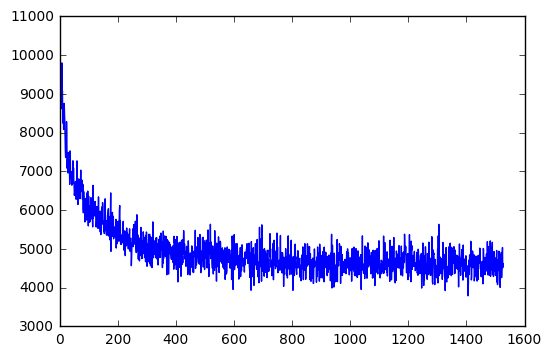

In [12]:
plt.plot(validloss[20:])

---
## Validating

This section outlines the validation that was done for the model after training.

In [19]:
# Function to create gifs from decoder output
def savegif(name, frames):
    with imageio.get_writer(name, mode='I') as writer:
        for f in frames:
            writer.append_data((inverse_transform(f)*255).astype(np.uint8))

In [20]:
# Function to display gifs
def disimgs(imgs):
    strs = ''
    for img in imgs:
        strs += '<img src="%s?rand=%f" width="200px"/><br/>'%(img, np.random.rand())
    return HTML(strs)

In [21]:
def filmstrip(video, name, skip=5):
    fig, ax = plt.subplots(nrows=1, ncols=video.shape[0]//skip, figsize=(20,4))
    for i in range(video.shape[0]//skip):
        axx = ax[i]
        axx.imshow(np.clip(inverse_transform(video[i*skip]), 0, 1))
        axx.axis('off')
    plt.tight_layout()
    plt.savefig(name)
itrand = 0

In [22]:
# Function to resize images and apply inverse transform
itrand = 0
def toint(frame):
    return scipy.misc.imresize((np.clip(inverse_transform(frame), 0, 1) * 255).astype(np.uint8), 
                          (frame.shape[0] * 10, frame.shape[1] * 10), interp='nearest')

In [16]:
# Single test

# Source demonstration
choicesrc = [1] * batch_size
# Target
choicetgt = [12] * batch_size
srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
tgtctx = validdata[0, choicetgt]
batch = [srcdata, tgtctx, tgtdata]

# Test 1
L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], {tfinput: batch, tftrain: False})

# Test 2
L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], {tfinput: batch, tftrain: False})


print(L, r1, r2)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts2[i]))
    axx.axis('off')
plt.tight_layout()


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts[i]))
    axx.axis('off')
plt.tight_layout()

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(tgtdata[i]))
    axx.axis('off')
plt.tight_layout()

4270.94 2202.08 2065.44
5657.87 2765.93 2877.75
7934.81 4626.82 3304.49
3728.42 2284.8 1439.23
4350.48 2927.74 1418.08
5382.0 3588.17 1788.86


KeyboardInterrupt: 

In [13]:
# 10-test

for kk in range(10):
    itrand += 1
    choicesrc = [np.random.randint(nvalid)] * batch_size
    choicetgt = [np.random.randint(nvalid)] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]

    L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], {tfinput: batch, tftrain: False})


    L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], {tfinput: batch, tftrain: False})


    print(L, r1, r2)

5344.84 3729.74 1610.49


In [204]:
# Calculating feature importance
feats = []
for i in range(nvalid):
    if i % 100 == 0:
        print(i)
    choicesrc = [i] * batch_size
    choicetgt = [1] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % nlen, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % nlen, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    feats.append(sess.run( test.translated_z, 
        {tftrain: False, tfinput: batch, keep_prob:1.0})[:nlen])

0
